# Tema 1 - Inteligenta Artificiala 
**Grigore Lucian-Florin** 343C4

In [5]:
# libraries used
import json
from math import inf
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import numpy as np
from heapq import heappop, heappush
from time import process_time
import tracemalloc

# macros for state template
ROWS = "rows"
COLUMNS = "columns"
GRID = "grid" 
HEIGHT = "height"
WIDTH = "width"
CURRENT_POSITION = "current_position"
TAG = "tag"
CHILDREN = "children"
PATH = "path"
PARENT = "parent"
NAME = "name"

# state tags
UNEXPLORED = "unexplored"
EXPLORED = "explored"
SOLVED = "solved"
UNSOLVABLE = "unsolvable"

# possible moves on the grid
COLOR, UP, LEFT, DOWN, RIGHT = 'color', 'up', 'left', 'down', 'right'
moves = [COLOR, UP, LEFT, DOWN, RIGHT]

# tests
tests = ['test1.json', 'test2.json', 'test3.json', 'test4.json', 'test5.json', 'test6.json']

In [6]:
# function to read and write data
def io_data(filename = "", data = None):
    if filename == "":
        raise ValueError("Invalid filename")
    if data is None:
        with open(filename, 'r') as f:
            return json.load(f)
    else:
        with open(filename, 'w') as f:
            json.dump(data, f)

def read_test(testname):
    data = io_data(testname)
    
    state = {}
    state[ROWS] = data[ROWS]
    state[COLUMNS] = data[COLUMNS]
    state[HEIGHT] = data[HEIGHT]
    state[WIDTH] = data[WIDTH]
    state[GRID] = [[0 for _ in range(state[WIDTH])] for _ in range(state[HEIGHT])]
    state[CURRENT_POSITION] = None
    state[PATH] = []
    state[PARENT] = None
    state[NAME] = data[NAME]
    
    return state

def read_solution(testname):
    data = io_data(testname)
    
    state = {}
    state[ROWS] = data[ROWS]
    state[COLUMNS] = data[COLUMNS]
    state[HEIGHT] = data[HEIGHT]
    state[WIDTH] = data[WIDTH]
    state[GRID] = data[GRID]
    state[CURRENT_POSITION] = None
    state[PATH] = []
    state[PARENT] = None
    state[NAME] = data[NAME]
    
    return state

In [7]:
def print_results(algoname, state, testname, time_duration, total_memory, no_gen_nodes, no_expanded_nodes, solution_path):
    print(f'=============== Test Analysis using {algoname} on test \'{testname}\' ===============')
    print(f'Total duration: {time_duration} seconds')
    print(f'Total memory used: {total_memory / 1024} KB')
    print(f'Number of generated nodes: {no_gen_nodes} nodes')
    print(f'Number of completely expanded nodes: {no_expanded_nodes} nodes')
    print(f'Path used to get to solution: {solution_path}')
    plt.imshow(state[GRID], cmap='Greys')
    plt.show()
    
def run(algoname, algo, init_state, testname):
    print(f'Generating state space for test \'{init_state[NAME]}\' ...')
    global all_rows
    all_rows = gen_all_rows(init_state[ROWS], init_state[WIDTH])
    print(f'Done generating state space!')
    
    print('Running algorithm...')
    state = deepcopy(init_state)
    start_time = process_time()
    sol = algo(state)
    end_time = process_time()
    time_duration = end_time - start_time
    
    state = deepcopy(init_state)
    tracemalloc.start()
    sol = algo(state)
    total_memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    
    global no_generated_nodes
    no_gen_nodes = no_generated_nodes
    global no_expanded_nodes
    no_exp_nodes = no_expanded_nodes
    
    if sol:
        print_results(algoname, sol, sol[NAME], time_duration, total_memory, no_gen_nodes, no_exp_nodes, sol[PATH])
    else:
        print('No solution found for given state using given algorithm')

def run_suite(algoname, algo, max_test_no = -1):
    if max_test_no >= 0:
        idx = 0
    for test in tests:
        init_state = read_test(test)
        run(algoname, algo, init_state, test)
        if max_test_no >= 0:
            idx += 1
            if idx == max_test_no:
                break

In [8]:
def check_rows(state):
    for i in range(state[HEIGHT]):
        lst = []
        curr_sum = 0
        for j in range(state[WIDTH]):
            if state[GRID][i][j] == 1:
                curr_sum += 1
            else:
                if curr_sum > 0:
                    lst.append(curr_sum)
                    curr_sum = 0
        if curr_sum > 0:
            lst.append(curr_sum)
        if lst != state[ROWS][i]:
            return False
    return True

def check_columns(state):
    for i in range(state[WIDTH]):
        lst = []
        curr_sum = 0
        for j in range(state[HEIGHT]):
            if state[GRID][j][i] == 1:
                curr_sum += 1
            else:
                if curr_sum > 0:
                    lst.append(curr_sum)
                    curr_sum = 0
        if curr_sum > 0:
            lst.append(curr_sum)
        if lst != state[COLUMNS][i]:
            return False
    return True

def is_state_final(state):
    return check_columns(state)

def is_state_in_list(s, lst):
    for state in lst:
        if s[CURRENT_POSITION] == state[CURRENT_POSITION] and s[GRID] == state[GRID]:
            return True
    return False

def validate(sol, idx, width, row):
    if idx < width - 1:
        return True
    lst = []
    curr_sum = 0
    for x in sol:
        if x == 1:
            curr_sum += 1
        else:
            if curr_sum > 0:
                lst.append(curr_sum)
                curr_sum = 0
    if curr_sum > 0:
        lst.append(curr_sum)
    return lst == row
        
def backtr_row(row, width):
    lst = []
    v = [-1 for _ in range(width)]
    init_val = -1
    inc_val = 1
    max_val = 1
    i = 0
    
    while i >= 0:
        done = False
        while not done and v[i] <= max_val:
            v[i] = v[i] + inc_val
            done = validate(v, i, width, row)
        if v[i] <= max_val:
            if i == width - 1:
                lst.append(copy(v))
            else:
                i += 1
        else:
            v[i] = init_val
            i -= 1
            
    return lst
    
def gen_all_rows(rows, width):
    return [backtr_row(row, width) for row in rows]

def gen_next_moves(state, row_index, all_rows):
    return all_rows[row_index]

Generating state space for test 'smile' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Breadth-First Search on test 'smile' ===============
Total duration: 0.004613999999999674 seconds
Total memory used: 58.2880859375 KB
Number of generated nodes: 28 nodes
Number of completely expanded nodes: 21 nodes
Path used to get to solution: [[1, 1, 0, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 1, 1, 1, 0]]


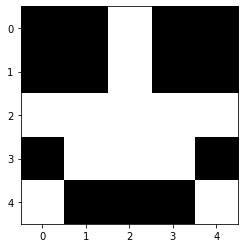

Generating state space for test 'tower' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Breadth-First Search on test 'tower' ===============
Total duration: 0.01809599999999989 seconds
Total memory used: 169.0224609375 KB
Number of generated nodes: 78 nodes
Number of completely expanded nodes: 50 nodes
Path used to get to solution: [[1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 1, 0]]


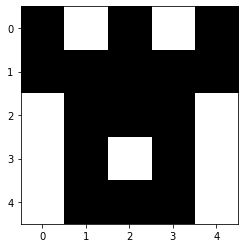

In [9]:
def bfs(init_state):
    global all_rows
    frontier = [(init_state, 0)]
    explored = []
    
    global no_generated_nodes
    global no_expanded_nodes
    no_generated_nodes = 1
    no_expanded_nodes = 0
    
    while frontier:
        curr_state, curr_row_index = frontier.pop(0)
        no_expanded_nodes += 1
        if curr_row_index == curr_state[HEIGHT]:
            if is_state_final(curr_state):
                return curr_state
            continue
            
        explored.append((curr_state, curr_row_index))
        next_moves = gen_next_moves(curr_state, curr_row_index, all_rows)
        if not next_moves:
            continue
                
        for next_move in next_moves:
            no_generated_nodes += 1
            child_state = deepcopy(curr_state)
            child_state[CURRENT_POSITION] = next_move
            child_state[GRID][curr_row_index] = next_move
            child_state[PATH].append(next_move)
            if (child_state, curr_row_index + 1) not in explored and (child_state, curr_row_index + 1) not in frontier:
                frontier.append((child_state, curr_row_index + 1))
    
    return None

run_suite("Breadth-First Search", bfs, 2)

Generating state space for test 'smile' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Depth-First Search on test 'smile' ===============
Total duration: 0.003105999999999831 seconds
Total memory used: 23.25 KB
Number of generated nodes: 19 nodes
Number of completely expanded nodes: 15 nodes
Path used to get to solution: [[1, 1, 0, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 1, 1, 1, 0]]


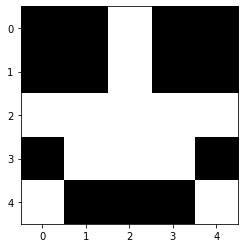

Generating state space for test 'tower' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Depth-First Search on test 'tower' ===============
Total duration: 0.014625999999999806 seconds
Total memory used: 41.7021484375 KB
Number of generated nodes: 48 nodes
Number of completely expanded nodes: 44 nodes
Path used to get to solution: [[1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 1, 0]]


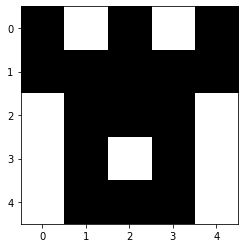

In [10]:
def dfs(init_state):
    global all_rows
    stack = [(init_state, 0)]
    explored = []
    
    global no_generated_nodes
    global no_expanded_nodes
    no_generated_nodes = 1
    no_expanded_nodes = 0
    
    while stack:
        curr_state, curr_row_index = stack.pop(0)
        no_expanded_nodes += 1
        if curr_row_index == curr_state[HEIGHT]:
            if is_state_final(curr_state):
                return curr_state
            continue
            
        explored.append((curr_state, curr_row_index))
        next_moves = gen_next_moves(curr_state, curr_row_index, all_rows)
        if not next_moves:
            continue
                
        for next_move in next_moves:
            no_generated_nodes += 1
            child_state = deepcopy(curr_state)
            child_state[CURRENT_POSITION] = next_move
            child_state[GRID][curr_row_index] = next_move
            child_state[PATH].append(next_move)
            
            if (child_state, curr_row_index + 1) not in explored and (child_state, curr_row_index + 1) not in stack:
                stack.insert(0, (child_state, curr_row_index + 1))
    
    return None

run_suite("Depth-First Search", dfs, 2)

Generating state space for test 'smile' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Iterative Deepening DFS on test 'smile' ===============
Total duration: 0.013325999999999283 seconds
Total memory used: 32.994140625 KB
Number of generated nodes: 19 nodes
Number of completely expanded nodes: 15 nodes
Path used to get to solution: [[1, 1, 0, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 1, 1, 1, 0]]


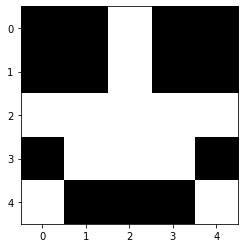

Generating state space for test 'tower' ...
Done generating state space!
Running algorithm...
=============== Test Analysis using Iterative Deepening DFS on test 'tower' ===============
Total duration: 0.0663020000000003 seconds
Total memory used: 60.8427734375 KB
Number of generated nodes: 48 nodes
Number of completely expanded nodes: 44 nodes
Path used to get to solution: [[1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 1, 0]]


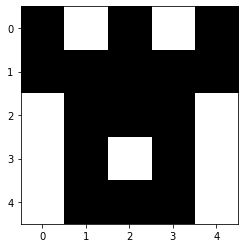

In [11]:
def dfs_max_depth(init_state, max_depth):
    global all_rows
    depth = 0
    stack = [(init_state, 0, 0)]
    explored = []
    
    global no_generated_nodes
    global no_expanded_nodes
    no_generated_nodes = 1
    no_expanded_nodes = 0
    
    while stack:
        curr_state, curr_depth, curr_row_index = stack.pop(0)
        no_expanded_nodes += 1
        
        if curr_depth > max_depth:
            continue
            
        if curr_row_index == curr_state[HEIGHT]:
            if is_state_final(curr_state):
                return curr_depth, curr_state
            continue
        
        explored.append((curr_state, curr_depth, curr_row_index))
        next_moves = gen_next_moves(curr_state, curr_row_index, all_rows)
        if not next_moves:
            continue
                
        for next_move in next_moves:
            no_generated_nodes += 1
            child_state = deepcopy(curr_state)
            child_state[CURRENT_POSITION] = next_move
            child_state[GRID][curr_row_index] = next_move
            child_state[PATH].append(next_move)
            
            if (child_state, curr_depth + 1, curr_row_index + 1) not in explored and (child_state, curr_depth +1, curr_row_index + 1) not in stack:
                stack.insert(0, (child_state, curr_depth + 1, curr_row_index + 1))
    
    return max_depth, None

def ids(state):
    depth = 0
    while depth < inf:
        init_state = deepcopy(state)
        curr_dfs_result = dfs_max_depth(init_state, depth)
        if curr_dfs_result[0] < depth:
            return curr_dfs_result[1]
        depth += 1
    return None

run_suite("Iterative Deepening DFS", ids, 2)

In [12]:
def function_cost1(state, sol):
    state_grid = state[GRID]
    sol_grid = sol[GRID]
    height = state[HEIGHT]
    width = state[WIDTH]
    cost = 0
    for i in range(height):
        for j in range(width):
            if state_grid[i][j] != sol_grid[i][j]:
                cost += 1
    return cost

def function_cost2(state, sol):
    cost = state[HEIGHT] * state[WIDTH]
    for i in range(state[HEIGHT]):
        row = state[GRID][state[HEIGHT] - i - 1]
        if sum(row) > 0:
            cost -= sum(row)
    return cost

In [13]:
class heap_node(object):
    def __init__(self, cost, state, idx):
        self.cost = cost
        self.state = state
        self.idx = idx
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def __gt__(self, other):
        return self.cost > other.cost
    
    def __eq__(self, other):
        return self.cost == other.cost
    
    def expand(self):
        return self.cost, self.state, self.idx
    
    def __str__(self):
        return f'cost={self.cost}, state={self.state}, row_index={self.idx}'
    
def astar(start_state, end_state, fcost):
    frontier = []
    heappush(frontier, heap_node(0 + fcost(start_state, end_state), start_state, 0))
    discovered = {(tuple(start_state[GRID][0]), 0): (None, 0)}
    
    global all_rows
    global no_generated_nodes
    global no_expanded_nodes
    no_generated_nodes = 1
    no_expanded_nodes = 0
    
    while frontier:
        curr_cost, curr_state, curr_row_index = heappop(frontier).expand()
        no_expanded_nodes += 1
        prev_cost = discovered[(tuple(curr_state[GRID][curr_row_index - 1]), curr_row_index)][1]
        
        if curr_row_index == curr_state[HEIGHT]:
            if is_state_final(curr_state):
                break
            continue
        
        next_moves = gen_next_moves(curr_state, curr_row_index, all_rows)
        for next_move in next_moves:
            next_move_cost = prev_cost + 1
            no_generated_nodes += 1
            
            if (tuple(next_move), curr_row_index + 1) not in discovered or next_move_cost < discovered[(tuple(next_move), curr_row_index + 1)][1]:
                discovered[(tuple(next_move), curr_row_index + 1)] = (curr_state, next_move_cost)
                curr_state[GRID][curr_row_index] = next_move
                next_state = deepcopy(curr_state)
                next_state[CURRENT_POSITION] = next_move
                next_state[GRID][curr_row_index] = next_move
                next_state[PARENT] = curr_state
                next_state[PATH].append(next_move)
                heappush(frontier, heap_node(next_move_cost + fcost(next_state, end_state), next_state, curr_row_index + 1))
                
    return curr_state[PATH], end_state

Generating state space for test 'smile' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'smile' ===============
Total duration: 0.006395999999999624 seconds
Total memory used: 42.1787109375 KB
Number of generated nodes: 13 nodes
Number of completely expanded nodes: 6 nodes
Path used to get to solution: [[1, 1, 0, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [0, 1, 1, 1, 0]]


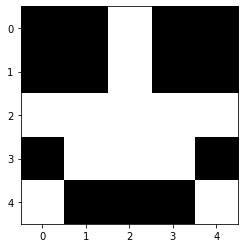

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'smile' ===============
Total duration: 0.012605999999999895 seconds
Total memory used: 41.15625 KB
Number of generated nodes: 28 nodes
Number of completely expanded nodes: 13 nodes
Path used to get to solution: [[1, 1, 0, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [0, 1, 0, 0, 1]]


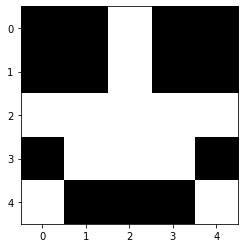

Generating state space for test 'tower' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'tower' ===============
Total duration: 0.015903999999999918 seconds
Total memory used: 47.1943359375 KB
Number of generated nodes: 15 nodes
Number of completely expanded nodes: 6 nodes
Path used to get to solution: [[1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 1, 0]]


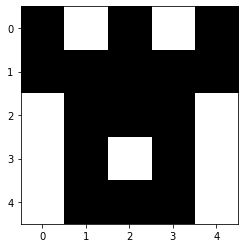

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'tower' ===============
Total duration: 0.01669799999999988 seconds
Total memory used: 46.4140625 KB
Number of generated nodes: 42 nodes
Number of completely expanded nodes: 15 nodes
Path used to get to solution: [[1, 0, 1, 0, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]]


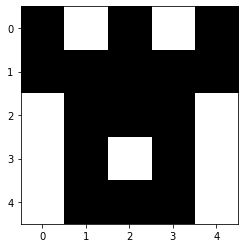

Generating state space for test 'music' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'music' ===============
Total duration: 0.2778659999999995 seconds
Total memory used: 787.2958984375 KB
Number of generated nodes: 150 nodes
Number of completely expanded nodes: 11 nodes
Path used to get to solution: [[0, 0, 0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1], [0, 1, 1, 1, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0, 1, 1, 0], [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]]


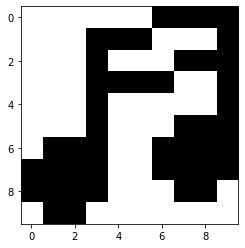

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'music' ===============
Total duration: 0.2555639999999997 seconds
Total memory used: 787.2333984375 KB
Number of generated nodes: 2471 nodes
Number of completely expanded nodes: 150 nodes
Path used to get to solution: [[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]]


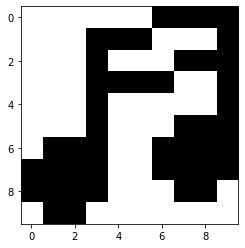

Generating state space for test 'mouse' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'mouse' ===============
Total duration: 9.347203999999998 seconds
Total memory used: 14222.62890625 KB
Number of generated nodes: 2015 nodes
Number of completely expanded nodes: 16 nodes
Path used to get to solution: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], [0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1,

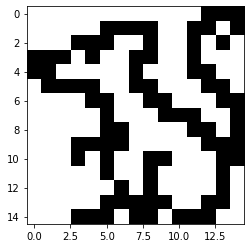

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'mouse' ===============
Total duration: 9.446432000000001 seconds
Total memory used: 14050.67578125 KB
Number of generated nodes: 296649 nodes
Number of completely expanded nodes: 2015 nodes
Path used to get to solution: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]]


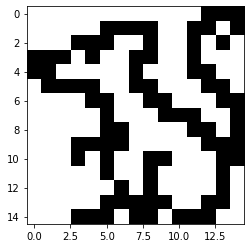

Generating state space for test 'doggie' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'doggie' ===============
Total duration: 10.725296000000014 seconds
Total memory used: 21270.37109375 KB
Number of generated nodes: 469463 nodes
Number of completely expanded nodes: 2455 nodes
Path used to get to solution: [[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


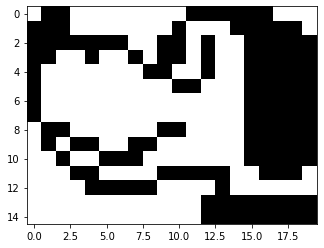

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'doggie' ===============
Total duration: 10.49454 seconds
Total memory used: 21230.90625 KB
Number of generated nodes: 469463 nodes
Number of completely expanded nodes: 2455 nodes
Path used to get to solution: [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]]


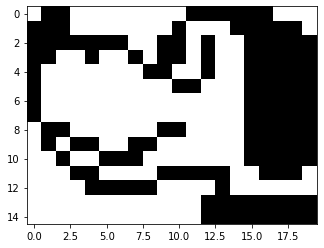

Generating state space for test 'train' ...
Done generating state space!
Running algorithm with first cost function...
=============== Test Analysis using A* with first cost function on test 'train' ===============
Total duration: 292.6673200000005 seconds
Total memory used: 336624.0390625 KB
Number of generated nodes: 25684 nodes
Number of completely expanded nodes: 26 nodes
Path used to get to solution: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,

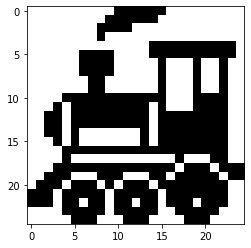

Running algorithm with second cost function...
=============== Test Analysis using A* with second cost function on test 'train' ===============
Total duration: 516.5348439999998 seconds
Total memory used: 337104.94921875 KB
Number of generated nodes: 76204261 nodes
Number of completely expanded nodes: 25684 nodes
Path used to get to solution: [[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


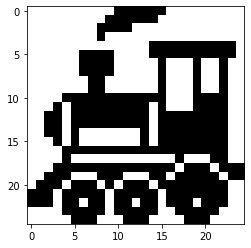

In [14]:
def run_astar(init_state, end_state, testname):
    print(f'Generating state space for test \'{end_state[NAME]}\' ...')
    global all_rows
    all_rows = gen_all_rows(init_state[ROWS], init_state[WIDTH])
    print(f'Done generating state space!')
    
    print('Running algorithm with first cost function...')
    state = deepcopy(init_state)
    sol_state = deepcopy(end_state)
    start_time = process_time()
    path, sol = astar(state, sol_state, function_cost1)
    end_time = process_time()
    time_duration = end_time - start_time

    state = deepcopy(init_state)
    sol_state = deepcopy(end_state)
    tracemalloc.start()
    path, sol = astar(state, end_state, function_cost1)
    total_memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    global no_generated_nodes
    no_gen_nodes = no_generated_nodes
    global no_expanded_nodes
    no_exp_nodes = no_expanded_nodes

    if sol:
        print_results("A* with first cost function", sol, end_state[NAME], time_duration, total_memory, no_gen_nodes, no_exp_nodes, path)
    else:
        print('No solution found for given state using given algorithm')
        
    print('Running algorithm with second cost function...')
    state = deepcopy(init_state)
    sol_state = deepcopy(end_state)
    start_time = process_time()
    path, sol = astar(state, sol_state, function_cost2)
    end_time = process_time()
    time_duration = end_time - start_time

    state = deepcopy(init_state)
    sol_state = deepcopy(end_state)
    tracemalloc.start()
    path, sol = astar(state, end_state, function_cost2)
    total_memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()

    no_gen_nodes = no_generated_nodes
    no_exp_nodes = no_expanded_nodes

    if sol:
        print_results("A* with second cost function", sol, end_state[NAME], time_duration, total_memory, no_gen_nodes, no_exp_nodes, path)
    else:
        print('No solution found for given state using given algorithm')

def run_suite_astar():
    for test in tests:
        init_state = read_test(test)
        end_state = read_solution('sol' + str(test))
        run_astar(init_state, end_state, test)

run_suite_astar()

In [11]:
def select():
    pass

def ac_3():
    pass

def bkt_mac(U, L, R, D):
    if not U:
        return True, L
    X = select(U)
    for x in domain(X):
        L_prime = deepcopy(L)
        L_prime.append((X, x))
        b, D_prime = ac_3(L_prime, R, D)
        if b:
            b, L = bkt_mac(U_prime, L_prime, R, D_prime)
            if b:
                return b, L
    return false

def mac(V, R, D):
    b, L = bkt_mac(V, [], R, D)
    if b:
        return L
    return None

def run_mac(testname):
    pass

In [12]:
def lrt_astar():
    pass